In [ ]:
import os

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import scikit_posthocs as sp
import scipy.stats as stats
from termcolor import colored

In [3]:
cwd = os.getcwd()
benchmark_result_path = os.path.realpath(os.path.join(cwd, "../data/app-results.csv"))

print(benchmark_result_path)

/Users/csalih/Developer/bsc-web-benchmark/benchmark/benchmark-analyze/data/app-results.csv


In [4]:
# Load the dataset
csv_headers = ["framework", "metric", "os", "browser", "value"]
df = pd.read_csv(benchmark_result_path, header=None, names=csv_headers)

df['value'] = pd.to_numeric(df['value'], errors='raise')

# Group the data
frameworks = df["framework"].unique()
metrics = df["metric"].unique()
browsers = df["browser"].unique()
operating_systems = df["os"].unique()

df_by_framework = df.groupby("framework")
df_by_metric = df.groupby("metric")

# Display basic info
pd.concat([df.head(5), df.tail(5)])

,framework,metric,os,browser,value
0,app-angular,create_1000_duration,darwin,chromium,56.2
1,app-angular,create_10000_duration,darwin,chromium,558.3
2,app-angular,append_1000_rows_duration,darwin,chromium,60.6
3,app-angular,update_every_10th_row_duration,darwin,chromium,4.6
4,app-angular,swap_rows_duration,darwin,chromium,10.3
17994,app-leptos,create_1000_duration,win32,webkit,332.0
17995,app-leptos,create_10000_duration,win32,webkit,4199.0
17996,app-leptos,append_1000_rows_duration,win32,webkit,319.0
17997,app-leptos,update_every_10th_row_duration,win32,webkit,41.0
17998,app-leptos,swap_rows_duration,win32,webkit,64.0


In [5]:
# Validate

# Check if there is sufficient data
if (
  df["framework"].nunique() < 0
  or df["browser"].nunique() < 0
  or df["os"].nunique() < 0
):
  raise Exception(f"Data has insufficient data.")

# Group by all factors and count the number of observations
counts = (
  df.groupby(["framework", "metric", "browser", "os"])
  .size()
  .reset_index(name="count")
)
single_observations = counts[counts["count"] == 1]

if not single_observations.empty:
  print("WARNING: The following groups have only one observation. ANOVA may fail:")
  print(single_observations)
  raise Exception("Consider combining levels or simplifying your model.")

In [6]:
for metric in metrics:
  data = df
  data = data[data.metric.eq(metric)]

  # Group by (browser, os) and compute descriptive statistics
  summary = data.groupby(['browser', 'os'])['value'].describe().map(lambda x: f"{x:0.2f}")

  # Convert to a clean format
  summary.index = [f"{b.capitalize()} ({o.capitalize()})" for b, o in summary.index]

  # Compute total row
  total_row = data['value'].describe().apply("{0:.2f}".format).to_frame().T
  total_row.index = ["Total"]
  summary = pd.concat([summary, total_row])

  # Rename columns for better readability
  summary = summary.drop(columns=['25%'])
  summary = summary.rename(columns={
    'count': 'Count', 'mean': 'Mean', 'std': 'Std',
    'min': 'Min', '50%': '50%', '75%': '75%', 'max': 'Max'
  })

  # Print the final summary
  print(colored("######################################################################", "light_blue"))
  print(colored(f"Results for Metric: {metric}", "light_blue"))
  print(colored("######################################################################", "light_blue"))
  print("")
  display(summary)

######################################################################
Results for Metric: create_1000_duration
######################################################################



,Count,Mean,Std,Min,50%,75%,Max
Chromium (Darwin),400.00,57.64,2.67,53.30,57.85,59.30,68.80
Chromium (Linux),400.00,217.89,14.13,196.80,220.10,228.00,367.60
Chromium (Win32),400.00,272.56,23.23,219.90,271.75,282.75,420.90
Firefox (Darwin),400.00,44.82,6.41,35.00,44.00,49.25,57.00
Firefox (Linux),400.00,155.85,30.57,116.00,152.50,187.25,415.00
Firefox (Win32),400.00,242.77,49.33,154.00,233.00,286.25,376.00
Webkit (Darwin),400.00,54.92,4.33,49.00,54.00,57.75,65.00
Webkit (Linux),400.00,254.82,15.03,227.00,258.50,267.00,286.00
Webkit (Win32),400.00,389.97,55.35,299.00,396.00,407.25,1011.00
Total,3600.00,187.91,115.48,35.00,206.20,264.00,1011.00


######################################################################
Results for Metric: create_10000_duration
######################################################################



,Count,Mean,Std,Min,50%,75%,Max
Chromium (Darwin),400.00,577.96,38.40,521.00,575.10,608.05,651.90
Chromium (Linux),400.00,2091.86,104.07,1884.90,2133.65,2156.73,2592.80
Chromium (Win32),400.00,2458.97,169.50,2243.20,2468.20,2511.25,4160.50
Firefox (Darwin),400.00,432.88,90.41,316.00,435.50,520.00,547.00
Firefox (Linux),400.00,1369.46,300.15,987.00,1502.50,1694.25,2417.00
Firefox (Win32),400.00,1673.90,257.28,1276.00,1702.00,1949.00,2189.00
Webkit (Darwin),400.00,821.43,60.73,743.00,831.00,877.00,914.00
Webkit (Linux),400.00,4442.00,882.47,2449.00,4781.00,4981.25,5263.00
Webkit (Win32),399.00,5735.89,1595.41,3737.00,5294.00,8001.50,8665.00
Total,3599.00,2177.27,1817.43,316.00,1740.00,2489.95,8665.00


######################################################################
Results for Metric: append_1000_rows_duration
######################################################################



,Count,Mean,Std,Min,50%,75%,Max
Chromium (Darwin),400.00,58.10,4.61,52.90,55.75,63.50,69.20
Chromium (Linux),400.00,225.29,24.20,195.80,211.35,250.10,313.60
Chromium (Win32),400.00,254.18,36.34,214.00,247.75,276.70,547.50
Firefox (Darwin),400.00,44.74,8.62,33.00,41.00,55.00,65.00
Firefox (Linux),400.00,145.30,30.30,110.00,131.00,188.00,239.00
Firefox (Win32),400.00,160.79,28.19,119.00,155.00,186.00,263.00
Webkit (Darwin),400.00,62.58,4.85,57.00,61.00,64.50,72.00
Webkit (Linux),400.00,277.07,15.02,253.00,273.50,289.25,381.00
Webkit (Win32),400.00,395.12,47.20,302.00,406.00,421.25,764.00
Total,3600.00,180.35,114.49,33.00,186.00,264.08,764.00


######################################################################
Results for Metric: update_every_10th_row_duration
######################################################################



,Count,Mean,Std,Min,50%,75%,Max
Chromium (Darwin),400.00,5.53,1.89,3.90,5.10,5.60,14.50
Chromium (Linux),400.00,23.75,6.78,14.10,21.45,30.00,35.60
Chromium (Win32),400.00,25.45,7.52,16.50,23.40,32.95,67.00
Firefox (Darwin),400.00,5.55,2.80,3.00,5.00,6.00,29.00
Firefox (Linux),400.00,15.46,2.97,11.00,15.00,17.25,36.00
Firefox (Win32),400.00,16.10,4.00,10.00,15.00,17.00,40.00
Webkit (Darwin),400.00,9.34,1.98,6.00,10.00,11.00,18.00
Webkit (Linux),400.00,46.26,9.93,24.00,46.00,53.00,70.00
Webkit (Win32),400.00,82.02,18.58,41.00,86.00,96.00,125.00
Total,3600.00,25.50,24.63,3.00,16.10,32.52,125.00


######################################################################
Results for Metric: swap_rows_duration
######################################################################



,Count,Mean,Std,Min,50%,75%,Max
Chromium (Darwin),400.00,19.13,17.90,5.10,10.40,23.50,54.30
Chromium (Linux),400.00,61.89,70.34,18.50,21.60,72.15,194.50
Chromium (Win32),400.00,72.87,84.51,21.90,24.80,87.67,340.20
Firefox (Darwin),400.00,22.80,11.98,12.00,17.50,30.50,46.00
Firefox (Linux),400.00,60.33,36.21,33.00,42.50,91.75,128.00
Firefox (Win32),400.00,67.37,40.06,32.00,48.00,90.50,158.00
Webkit (Darwin),400.00,26.48,25.21,10.00,13.00,32.75,72.00
Webkit (Linux),400.00,109.50,96.89,40.00,55.00,135.25,314.00
Webkit (Win32),400.00,167.91,159.13,56.00,82.00,348.00,472.00
Total,3600.00,67.59,87.36,5.10,40.00,70.00,472.00


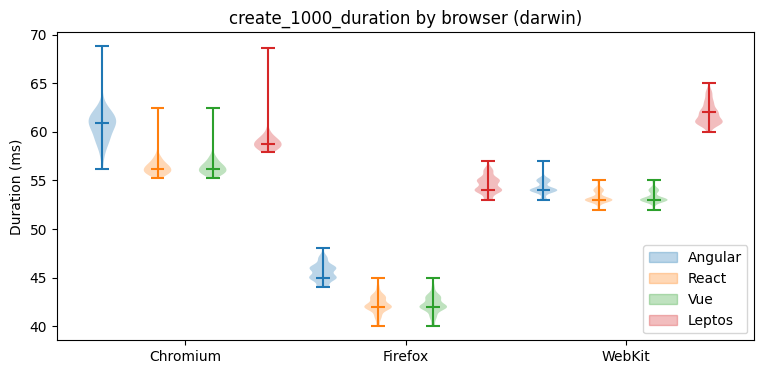

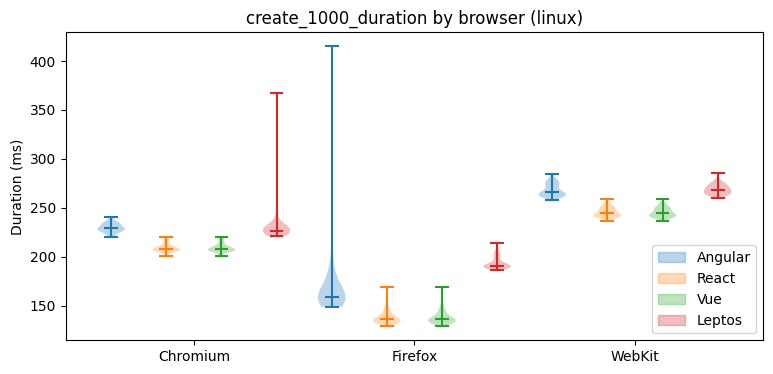

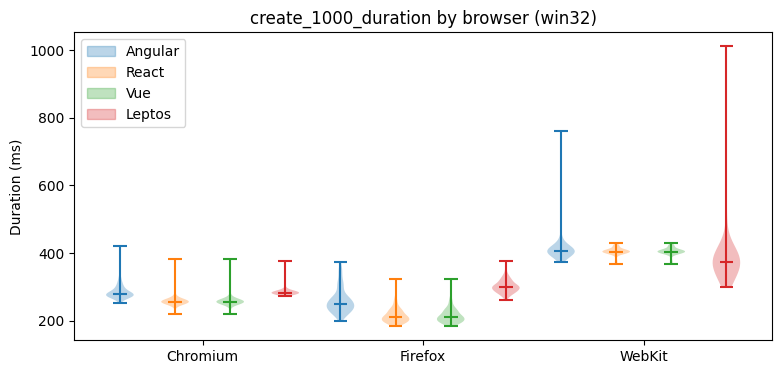

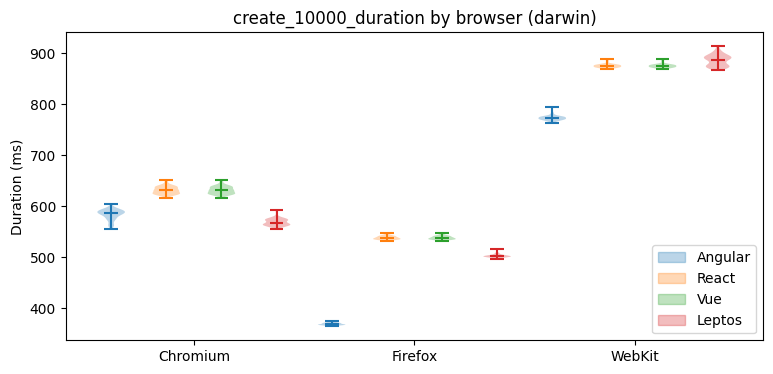

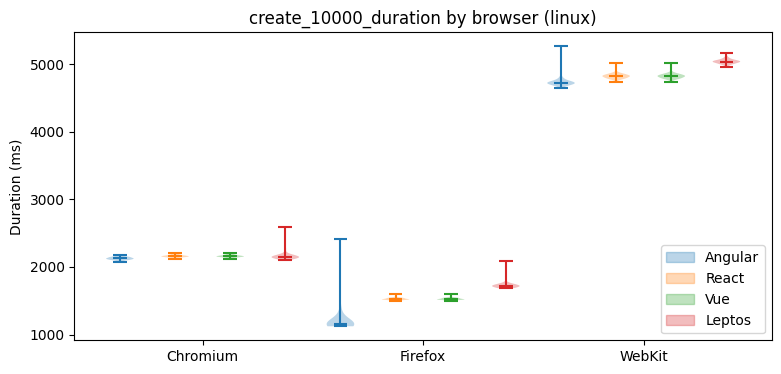

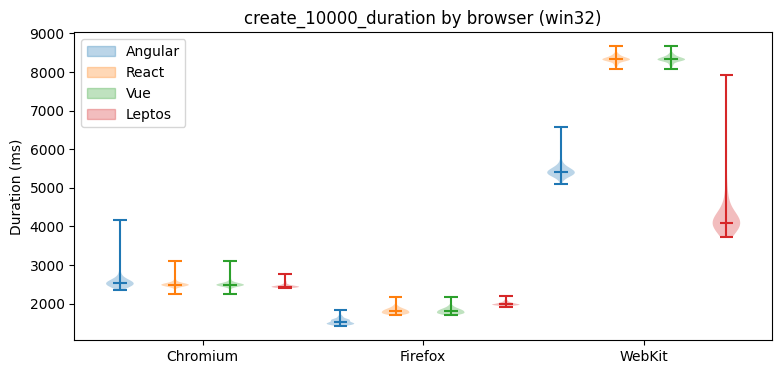

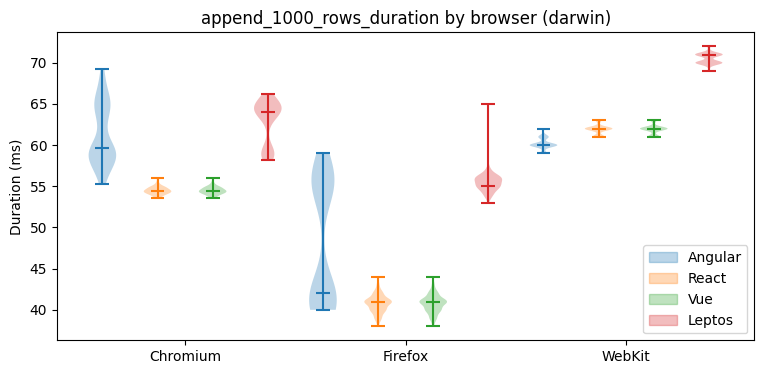

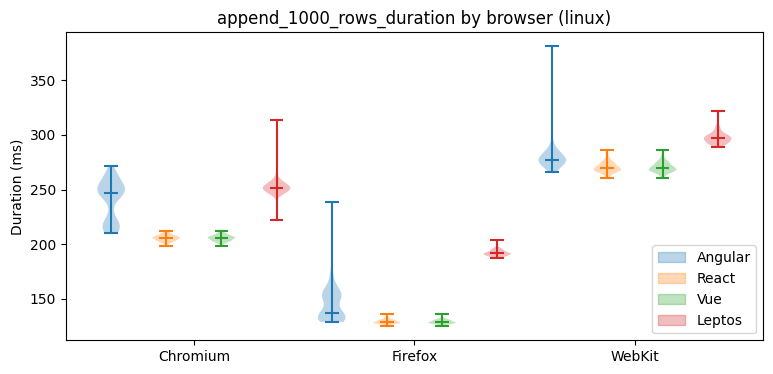

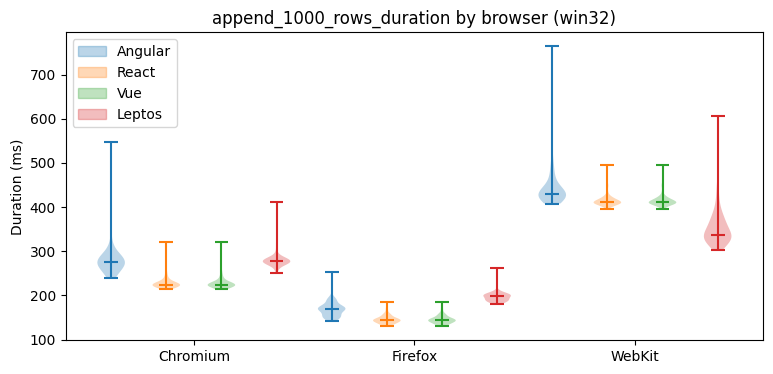

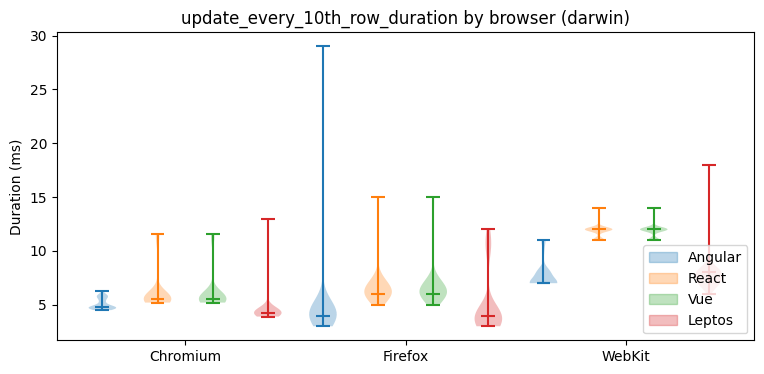

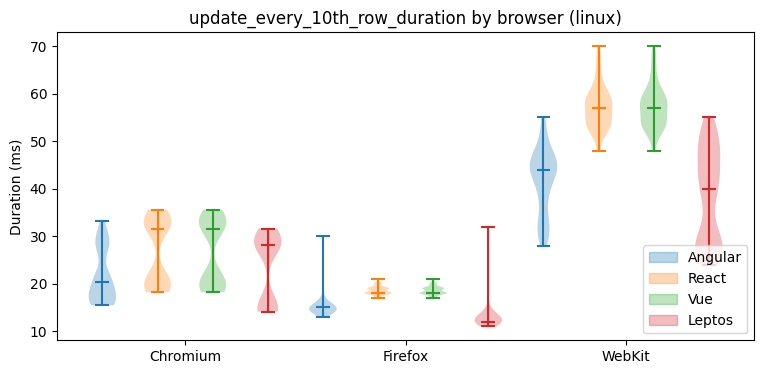

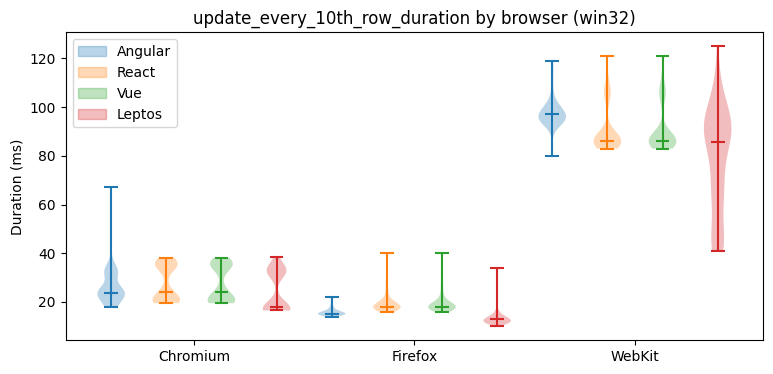

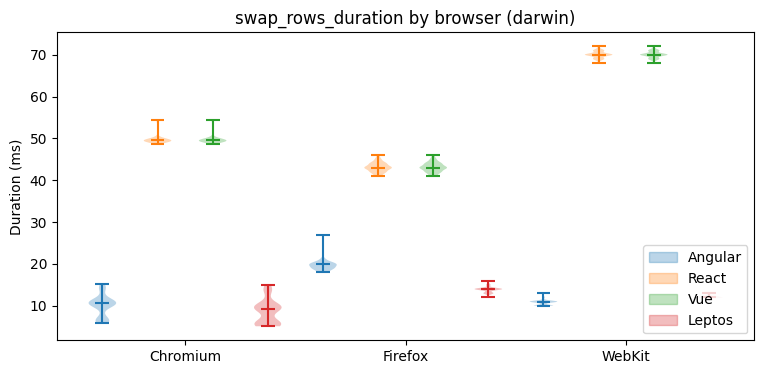

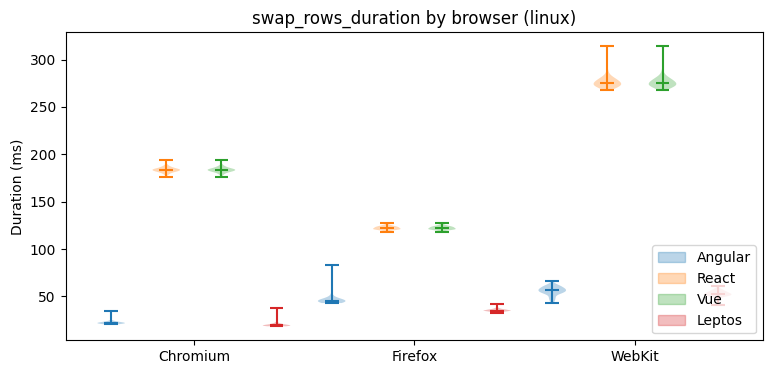

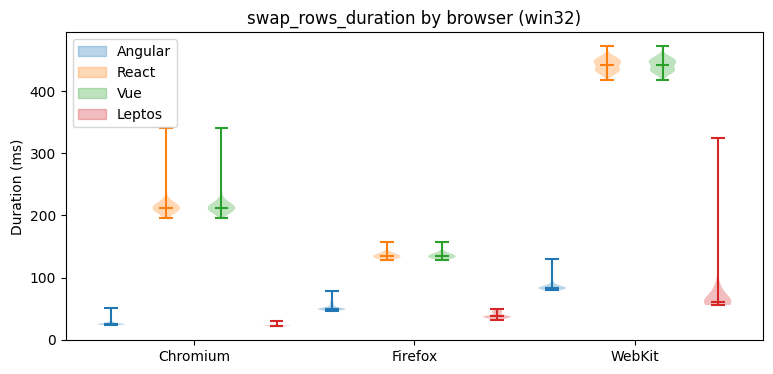

In [7]:
for metric in metrics:
  for idx_os, os in enumerate(operating_systems):
    labels = []


    def add_label(violin, label):
      color = violin["bodies"][0].get_facecolor().flatten()
      labels.append((mpatches.Patch(color=color), label))


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

    nameDF = df
    #nameDF = nameDF[nameDF.framework.eq(framework)]
    nameDF = nameDF[nameDF.os.eq(os)]
    #nameDF = nameDF[nameDF.browser.eq(browser)]
    nameDF = nameDF[nameDF.metric.eq(metric)]

    positions = [[1, 5, 9], [2, 6, 10], [3, 7, 11], [4, 8, 12]]

    # Conduit Angular
    offset = 1
    data = nameDF[nameDF.framework.eq("app-angular")]
    durations = [group['value'] for _, group in data.groupby(['browser'])]
    rects = ax.violinplot(durations, positions[0], showmeans=False, showmedians=True)
    add_label(rects, "Angular")

    # Conduit React
    data = nameDF[nameDF.framework.eq("app-react")]
    durations = [group['value'] for _, group in data.groupby(['browser'])]
    rects = ax.violinplot(durations, positions[1], showmeans=False, showmedians=True)
    add_label(rects, "React")

    data = nameDF[nameDF.framework.eq("app-react")]
    durations = [group['value'] for _, group in data.groupby(['browser'])]
    rects = ax.violinplot(durations, positions[2], showmeans=False, showmedians=True)
    add_label(rects, "Vue")

    data = nameDF[nameDF.framework.eq("app-leptos")]
    durations = [group['value'] for _, group in data.groupby(['browser'])]
    rects = ax.violinplot(durations, positions[3], showmeans=False, showmedians=True)
    add_label(rects, "Leptos")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(f'{metric} by browser ({os})')
    ax.set_ylabel('Duration (ms)')
    ax.set_xticks([2.5, 6.5, 10.5], ["Chromium", "Firefox", "WebKit"])

    # Legend
    location = "upper left" if os == "win32" else "lower right"
    ax.legend(*zip(*labels), loc=location)
    #plt.legend(*zip(*labels), loc='upper right')

    plt.show()
    ax.set_title("")
    fig.savefig(f"output/{metric}_{os}.pdf")


In [8]:
alpha = 0.05

for metric in metrics:
  for browser in browsers:
    for os in operating_systems:
      # Data
      data = df
      data = data[data.os.eq(os)]
      data = data[data.browser.eq(browser)]
      data = data[data.metric.eq(metric)]
      data['rank'] = data['value'].rank(method='average')

      # Kruskal-Wallis H-test
      statistic, pvalue = stats.kruskal(*[group["value"].values for _, group in data.groupby("framework")])

      # Statistic description
      statistic_description = data['value'].describe().apply("{0:.2f}".format)

      # Post-Hoc Analysis
      posthoc_results = sp.posthoc_dunn(data, group_col='framework', val_col='value', p_adjust='bonferroni')

      # Calculate mean ranks
      mean_ranks = data.groupby('framework')['rank'].mean()
      pairs = []
      for g1 in mean_ranks.index:
        for g2 in mean_ranks.index:
          if g1 != g2:
            diff = mean_ranks[g1] - mean_ranks[g2]
            pairs.append((g1, g2, diff))

      print(colored("######################################################################", "light_blue"))
      print(colored(f"Results for Metric: {metric} {os} {browser}", "light_blue"))
      print(colored("######################################################################", "light_blue"))
      print("")

      print("Kruskal-Wallis H-test:")
      print(f"Statistics: {statistic:.2f}")
      print(f"p-value: {colored(f'{pvalue}', 'green' if pvalue < alpha else 'red')}")

      print("______________________________________________________________________")
      print("Statistic Description:")
      print(statistic_description)
      print("______________________________________________________________________")

      print("\nMean rank differences:")
      for g1, g2, diff in pairs:
        color = "green" if posthoc_results[g1][g2] < alpha else "red"

        print(f"{g1} vs {g2}:", colored(f"{diff:.2f}", color), f"(p-value: {posthoc_results[g1][g2]})")
      print("")


######################################################################
Results for Metric: create_1000_duration darwin chromium
######################################################################

Kruskal-Wallis H-test:
Statistics: 336.35
p-value: 1.343087005652153e-72
______________________________________________________________________
Statistic Description:
count    400.00
mean      57.64
std        2.67
min       53.30
25%       55.48
50%       57.85
75%       59.30
max       68.80
Name: value, dtype: object
______________________________________________________________________

Mean rank differences:
app-angular vs app-leptos: 69.53 (p-value: 0.00012658979736244547)
app-angular vs app-react: 179.94 (p-value: 2.1433109555514697e-27)
app-angular vs app-vue: 278.03 (p-value: 4.405680982997061e-64)
app-leptos vs app-angular: -69.53 (p-value: 0.00012658979736244547)
app-leptos vs app-react: 110.41 (p-value: 8.680826608200743e-11)
app-leptos vs app-vue: 208.51 (p-value: 1.7856346390

In [9]:
# Perform Friedman test for each metric
for metric in metrics:
  subset = df[df['metric'] == metric]
  pivot_df = subset.pivot_table(index=['framework'], columns=['browser', 'os'], values='value', aggfunc='median')

  # Drop any rows with NaN values (if missing observations)
  pivot_df = pivot_df.dropna()

  # Ensure we have enough samples for the test
  if pivot_df.shape[1] > 2:  # Friedman test requires at least 3 groups
    stat, p = stats.friedmanchisquare(*[pivot_df[col] for col in pivot_df.columns])
    print(f"Friedman test for {metric} across (Browser, OS) combinations: χ²={stat:.4f}, p={p:.4f}")

    if p < 0.05:
      print("Significant difference found! ")

# Perform Wilcoxon signed-rank test for (Browser, OS) pairs
browser_os_combinations = df[['browser', 'os']].drop_duplicates().values

for metric in df['metric'].unique():
  subset = df[df['metric'] == metric]

  for i in range(len(browser_os_combinations)):
    for j in range(i + 1, len(browser_os_combinations)):
      b1, os1 = browser_os_combinations[i]
      b2, os2 = browser_os_combinations[j]

      group1 = subset[(subset['browser'] == b1) & (subset['os'] == os1)]['value']
      group2 = subset[(subset['browser'] == b2) & (subset['os'] == os2)]['value']

      if len(group1) == len(group2):  # Wilcoxon requires paired samples
        stat, p = stats.wilcoxon(group1, group2, zero_method='wilcox')
        print(f"Wilcoxon test between ({b1}, {os1}) and ({b2}, {os2}) for {metric}: W={stat:.4f}, p={p:.4f}")


Friedman test for create_1000_duration across (Browser, OS) combinations: χ²=30.8667, p=0.0001
Significant difference found! 
Friedman test for create_10000_duration across (Browser, OS) combinations: χ²=31.8000, p=0.0001
Significant difference found! 
Friedman test for append_1000_rows_duration across (Browser, OS) combinations: χ²=32.0000, p=0.0001
Significant difference found! 
Friedman test for update_every_10th_row_duration across (Browser, OS) combinations: χ²=31.5472, p=0.0001
Significant difference found! 
Friedman test for swap_rows_duration across (Browser, OS) combinations: χ²=29.8000, p=0.0002
Significant difference found! 
Wilcoxon test between (chromium, darwin) and (firefox, darwin) for create_1000_duration: W=0.0000, p=0.0000
Wilcoxon test between (chromium, darwin) and (webkit, darwin) for create_1000_duration: W=12512.5000, p=0.0000
Wilcoxon test between (chromium, darwin) and (chromium, linux) for create_1000_duration: W=0.0000, p=0.0000
Wilcoxon test between (chromi

In [10]:
# Function to compute Cliff's Delta
def cliffs_delta(x, y):
  from itertools import product
  n, m = len(x), len(y)
  pairs = [1 if a > b else -1 if a < b else 0 for a, b in product(x, y)]
  delta = sum(pairs) / (n * m)
  return delta


# Compute Cliff's Delta for framework comparisons
for metric in metrics:
  subset = df[df['metric'] == metric]

  for i in range(len(frameworks)):
    for j in range(i + 1, len(frameworks)):
      fw1, fw2 = frameworks[i], frameworks[j]
      group1 = subset[subset['framework'] == fw1]['value']
      group2 = subset[subset['framework'] == fw2]['value']

      delta = cliffs_delta(group1, group2)
      print(f"Cliff’s Delta between {fw1} and {fw2} for {metric}: {delta:.4f}")


Cliff’s Delta between app-angular and app-leptos for create_1000_duration: -0.0940
Cliff’s Delta between app-angular and app-react for create_1000_duration: 0.1586
Cliff’s Delta between app-angular and app-vue for create_1000_duration: 0.2029
Cliff’s Delta between app-leptos and app-react for create_1000_duration: 0.2285
Cliff’s Delta between app-leptos and app-vue for create_1000_duration: 0.2807
Cliff’s Delta between app-react and app-vue for create_1000_duration: 0.1066
Cliff’s Delta between app-angular and app-leptos for create_10000_duration: -0.0420
Cliff’s Delta between app-angular and app-react for create_10000_duration: -0.1029
Cliff’s Delta between app-angular and app-vue for create_10000_duration: 0.1295
Cliff’s Delta between app-leptos and app-react for create_10000_duration: -0.0247
Cliff’s Delta between app-leptos and app-vue for create_10000_duration: 0.1602
Cliff’s Delta between app-react and app-vue for create_10000_duration: 0.1840
Cliff’s Delta between app-angular an

In [11]:
# Analyze each combination
for metric in metrics:
  for os_name in operating_systems:
    for browser_name in browsers:
      subset = df[
        (df['metric'] == metric) &
        (df['os'] == os_name) &
        (df['browser'] == browser_name)
        ]
      # Skip if not enough data
      if len(subset['framework'].unique()) < 2:
        raise Exception(f"Insufficient data for {metric} ({os_name}, {browser_name})")

      # Prepare data for Kruskal-Wallis (group by framework)
      groups = [
        grp['value'].values
        for f, grp in subset.groupby('framework')
      ]

      kw_stat, kw_p = stats.kruskal(*groups)

      print(f"\nMetric: {metric}, OS: {os_name}, Browser: {browser_name}")
      print(f"Kruskal-Wallis p-value: {kw_p:.4g}")

      # If significant, do Dunn's test
      if kw_p < 0.05:
        print("Significant difference found. Performing Dunn's test...")
        dunn_result = sp.posthoc_dunn(
          subset,
          val_col='value',
          group_col='framework',
          p_adjust='bonferroni'
        )
        print(dunn_result)

      # Compute ranks to see which framework is fastest on average
      subset = subset.copy()
      subset['rank'] = subset['value'].rank(method='average')
      # Lower value => faster => lower rank => invert to get "fastest first"
      rank_summary = subset.groupby('framework')['value'].mean().sort_values()
      print("Framework performance ranking (fastest first):")
      for f, val in rank_summary.items():
        print(f"  {f}: mean={val:.2f}")


Metric: create_1000_duration, OS: darwin, Browser: chromium
Kruskal-Wallis p-value: 1.343e-72
Significant difference found. Performing Dunn's test...
              app-angular    app-leptos     app-react       app-vue
app-angular  1.000000e+00  1.265898e-04  2.143311e-27  4.405681e-64
app-leptos   1.265898e-04  1.000000e+00  8.680827e-11  1.785635e-36
app-react    2.143311e-27  8.680827e-11  1.000000e+00  1.180416e-08
app-vue      4.405681e-64  1.785635e-36  1.180416e-08  1.000000e+00
Framework performance ranking (fastest first):
  app-vue: mean=54.51
  app-react: mean=56.39
  app-leptos: mean=58.97
  app-angular: mean=60.67

Metric: create_1000_duration, OS: darwin, Browser: firefox
Kruskal-Wallis p-value: 4.108e-81
Significant difference found. Performing Dunn's test...
              app-angular    app-leptos     app-react       app-vue
app-angular  1.000000e+00  3.757361e-09  8.831321e-09  1.272309e-33
app-leptos   3.757361e-09  1.000000e+00  1.272309e-33  5.999422e-75
app-react  

In [12]:
# Compute median-based ranking
ranked_frameworks = df.groupby(['metric', 'framework'])['value'].median().reset_index()
ranked_frameworks['rank'] = ranked_frameworks.groupby('metric')['value'].rank(method='dense', ascending=True)

# Perform Kruskal-Wallis test per metric
kruskal_results = {}
for metric in df['metric'].unique():
  grouped_data = [df[df['framework'] == fw]['value'].values for fw in df['framework'].unique()]
  stat, p_value = stats.kruskal(*grouped_data)
  kruskal_results[metric] = p_value

effect_sizes = []
frameworks = df['framework'].unique()
for metric in df['metric'].unique():
  subset = df[df['metric'] == metric]
  for i in range(len(frameworks)):
    for j in range(i + 1, len(frameworks)):
      fw1, fw2 = frameworks[i], frameworks[j]
      group1 = subset[subset['framework'] == fw1]['value']
      group2 = subset[subset['framework'] == fw2]['value']

      if len(group1) > 0 and len(group2) > 0:
        delta = cliffs_delta(group1, group2)
        effect_sizes.append({'metric': metric, 'framework_1': fw1, 'framework_2': fw2, 'cliffs_delta': delta})

effect_sizes_df = pd.DataFrame(effect_sizes)

# Create final ranking table
rank_table = ranked_frameworks.pivot(index='framework', columns='metric', values='rank')
# Convert ranks to integers
rank_table.loc['kruskal_p_value'] = [kruskal_results[metric] for metric in rank_table.columns.tolist()]
rank_table['mean_rank'] = rank_table.mean(axis=1)
rank_table = rank_table.sort_values('mean_rank')

display(rank_table)


metric,append_1000_rows_duration,create_10000_duration,create_1000_duration,swap_rows_duration,update_every_10th_row_duration,mean_rank
framework,,,,,,
kruskal_p_value,1.100978e-39,1.100978e-39,1.100978e-39,1.100978e-39,1.100978e-39,1.100978e-39
app-vue,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.400000e+00
app-leptos,4.000000e+00,4.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,2.600000e+00
app-angular,3.000000e+00,2.000000e+00,4.000000e+00,3.000000e+00,2.000000e+00,2.800000e+00
app-react,2.000000e+00,3.000000e+00,2.000000e+00,4.000000e+00,3.000000e+00,2.800000e+00
